In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.special import rel_entr

In [2]:
################## DATA FRAME ##################
datafile = 'Data/Fitbit_Kaggle/dailyActivity_merged.csv'
all_fields = ['Id', 'ActivityDate', 'TotalSteps', 'TotalDistance', 'TrackerDistance', 
          'VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance', 'SedentaryActiveDistance', 
          'VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories']

#pd.set_option('display.max_rows', 100)
df = pd.read_csv(datafile, skipinitialspace=True, usecols=all_fields)
fields = 'FairlyActiveMinutes'
selected_data = df[['Id',fields]]
n_rows, n_cols = df.shape

In [3]:
selected_data.head()

,Id,FairlyActiveMinutes
0,1503960366,13
1,1503960366,19
2,1503960366,11
3,1503960366,34
4,1503960366,10


In [4]:
all_IDs = df.Id.unique()
num_users = len(all_IDs)

user_dict = dict()
for idx, user in enumerate(all_IDs):
    temp_df = df.loc[df['Id'] == user]
    user_dict[user] = temp_df[fields].values

In [5]:
test_IDs = all_IDs[[0, 1]]  # [0, 5, 6, 10, 11, 15, 16, 20, 25, 30]
training_IDs = [ID for ID in all_IDs if ID not in test_IDs]
attack_IDs = list(test_IDs) + list(training_IDs[0:2])

ths = [0,2,5]

In [6]:
print(test_IDs)
print()
print(user_dict[test_IDs[0]])
print()
print(user_dict[training_IDs[1]])

[1503960366 1624580081]

[13 19 11 34 10 20 16 31 12  8 27 21  5 14 23 11 28 12 34 35 15 24 22 24
  6 46  8 11 31 23  0]

[ 0  0  0  0  0  8 12  0  0 13  0  0  0  0  0  0  0  0  0  7  0  0  0  0
  0  0  0  0  0  0  0]


In [7]:
for ID in training_IDs:
    print(user_dict[ID])
    print(len(user_dict[ID]))
    print(ID)

[51 16 58  4 42 13 33 58  0  0  0 15  0  1 41  0 53  0 71 24  7 94  0 12
  6 17  0  6 19  0]
30
1644430081
[ 0  0  0  0  0  8 12  0  0 13  0  0  0  0  0  0  0  0  0  7  0  0  0  0
  0  0  0  0  0  0  0]
31
1844505072
[0 0 9 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 1 8 0 0 0 0 0 0 0 0 0 0]
31
1927972279
[14  5  3  9 11 29  3  7 63 53 10  0 26  8 24 20 20 40 23 28  8 14 27 20
 17  2  0 47 28 25 16]
31
2022484408
[8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31
2026352035
[ 9  0  0  0  0  0  7 11 11 10  0  0  0  5  0  0  0  0  0  0  6 10  0 11
  0  0  0  0  0  0  0]
31
2320127002
[13 32 48 24 72  7 16  7 43 26 27 35  0 11  0  9  0  0]
18
2347167796
[21  8  0  0  1  8  6  0  5 10  0  5  1  0  5  0  7 23 20 18  7  6  0 23
  5 11  0  0  0  0  0]
31
2873212765
[ 0  8 25  0  0  2  7  0  3  9  0  2  7  0  2 13  0  0  4  0]
20
3372868164
[ 19  46  23  42  83  58  95  67  98   0  12  92  95   9  95  10   8  32
  52  40 143  41  96  88  55  86 116 122 115   0]
30
3977333714
[15  0  0 18 2

In [8]:
max_elements = 31
k_vec = list(range(1,31))
k_vec = [1,5,10,15,20,25,30]

data_storage = np.zeros((len(attack_IDs), len(training_IDs), len(ths), max_elements, len(k_vec)))

In [9]:
def isMatch(v1,v2,k,th):
    '''
    Are a match is there is a common k-subsequence that is matched with L1 dist <= th
    '''
    
    # If len(v1)=31 and k=31, then this is range(0,1) ---- k <= len(v1)
    for i in range(0,len(v1)-k+1):
        #print(i)
        a = np.array([v1[i:i+k]])
        for j in range(0,len(v2)-k+1):
            b = np.array([v2[i:i+k]])
            
            #print(f"{i, j}: Shape A: {a.shape}, Shape B: {b.shape}")
            # Should I zero pad b, truncate a, or just return false?
            while (a.shape[1] > b.shape[1]):
                #print(f"{a.shape[1]} > {b.shape[1]}")
                b = np.append(b, 0)
                #
                b = np.reshape(b, (1, len(b)))
                #try:
                #    print(f"{a.shape[1]} > {b.shape[1]}?")
                #except IndexError:
                #    b = np.reshape(b, (1, len(b)))
                #    print(f"{a.shape[1]} > {b.shape[1]}?")
                #print()
            
            if (np.linalg.norm((a - b), ord=1) <= th):
                return True
            
    return False

In [10]:
matching_matrix = np.zeros((len(attack_IDs), len(training_IDs), len(ths)))
for i, attack_ID in enumerate(attack_IDs):
    v1 = user_dict[attack_ID]
    k = len(v1) #len of the subsequence in the attack vector -> k =len(v1) means match the whole vector
    
    for j, training_ID in enumerate(training_IDs[:2]):
        #for k, training_value in enumerate(user_dict[training_ID]):
        v2 = user_dict[training_ID]
        
        for l, th in enumerate(ths):
            if (isMatch(v1,v2,k,th)):
                print(str(attack_ID) + " vs " + str(training_ID) + " is a Match")
                matching_matrix[i,j,l] = 1
           

1644430081 vs 1644430081 is a Match
1644430081 vs 1644430081 is a Match
1644430081 vs 1644430081 is a Match
1844505072 vs 1844505072 is a Match
1844505072 vs 1844505072 is a Match
1844505072 vs 1844505072 is a Match


In [11]:
matching_matrix = np.zeros((len(attack_IDs), len(training_IDs), len(ths), len(k_vec)))
for i, attack_ID in enumerate(attack_IDs):
    v1 = user_dict[attack_ID]
    for k_idx, k in enumerate(k_vec):
        #print(k)
        for j, training_ID in enumerate(training_IDs[:2]):
            #for k, training_value in enumerate(user_dict[training_ID]):
            v2 = user_dict[training_ID]

            for l, th in enumerate(ths):
                if (isMatch(v1,v2,k,th)):
                    #print(str(attack_ID) + " vs " + str(training_ID) + " is a Match")
                    matching_matrix[i,j,l,k_idx] = 1
            #print()

In [12]:
n_attack_training = len(attack_IDs) - len(test_IDs)
true_positives = np.zeros((len(ths), len(k_vec)))
false_negatives = np.zeros((len(ths), len(k_vec)))

for attack_idx, attack_ID in enumerate(attack_IDs):
    if attack_ID in training_IDs:
        label_idx = training_IDs.index(attack_ID)
        for j in range(len(ths)):
            for k_idx in range(len(k_vec)):
                if matching_matrix[attack_idx, label_idx, j, k_idx] == 1:
                    true_positives[j, k_idx] += 1
                else:
                    false_negatives[j, k_idx] += 1                    
                    
for j in range(len(ths)):
    for k_idx in range(len(k_vec)):
        #print(f"{j}, {k_idx}")
        if true_positives[j, k_idx] == n_attack_training:
            # Note that this is not necessarily mean all of them were true positives
            print(f"Th={ths[j]}, k={k_vec[k_idx]}: Correct number of positives found ({int(true_positives[j, k_idx])})!")
        else:
            print(f"Th={ths[j]}, k={k_vec[k_idx]}: Incorrect number of positives... found ({int(true_positives[j, k_idx])}) vs expected ({n_attack_training})")

Th=0, k=1: Correct number of positives found (2)!
Th=0, k=5: Correct number of positives found (2)!
Th=0, k=10: Correct number of positives found (2)!
Th=0, k=15: Correct number of positives found (2)!
Th=0, k=20: Correct number of positives found (2)!
Th=0, k=25: Correct number of positives found (2)!
Th=0, k=30: Correct number of positives found (2)!
Th=2, k=1: Correct number of positives found (2)!
Th=2, k=5: Correct number of positives found (2)!
Th=2, k=10: Correct number of positives found (2)!
Th=2, k=15: Correct number of positives found (2)!
Th=2, k=20: Correct number of positives found (2)!
Th=2, k=25: Correct number of positives found (2)!
Th=2, k=30: Correct number of positives found (2)!
Th=5, k=1: Correct number of positives found (2)!
Th=5, k=5: Correct number of positives found (2)!
Th=5, k=10: Correct number of positives found (2)!
Th=5, k=15: Correct number of positives found (2)!
Th=5, k=20: Correct number of positives found (2)!
Th=5, k=25: Correct number of positiv

In [16]:
precision = np.zeros((len(ths), len(k_vec)))
recall = np.zeros((len(ths), len(k_vec)))
accuracy = np.zeros((len(ths), len(k_vec)))

for j in range(len(ths)):
    for k_idx in range(len(k_vec)):
        all_positives = np.count_nonzero(matching_matrix[:,:,j,k_idx] == 1) 
        false_positives = all_positives - true_positives[j, k_idx]
        true_negatives = np.product(matching_matrix.shape) - all_positives - false_negatives[j, k_idx]

        precision[j, k_idx] = true_positives[j, k_idx] / (true_positives[j, k_idx] + false_positives)
        print(f"Th={ths[j]}, k={k_vec[k_idx]}: Precision of {precision[j, k_idx]*100:.2f}")
        recall[j, k_idx] = true_positives[j, k_idx] / (true_positives[j, k_idx] + false_negatives[j, k_idx])
        print(f"Th={ths[j]}, k={k_vec[k_idx]}: Recall of {recall[j, k_idx]*100:.2f}")
        accuracy[j, k_idx] = (true_positives[j, k_idx] + true_negatives) / np.product(matching_matrix.shape)
        print(f"Th={ths[j]}, k={k_vec[k_idx]}: Accuracy of {accuracy[j, k_idx]*100:.2f}")
        print()

Th=0, k=1: Precision of 25.00
Th=0, k=1: Recall of 100.00
Th=0, k=1: Accuracy of 99.77

Th=0, k=5: Precision of 66.67
Th=0, k=5: Recall of 100.00
Th=0, k=5: Accuracy of 99.96

Th=0, k=10: Precision of 66.67
Th=0, k=10: Recall of 100.00
Th=0, k=10: Accuracy of 99.96

Th=0, k=15: Precision of 100.00
Th=0, k=15: Recall of 100.00
Th=0, k=15: Accuracy of 100.00

Th=0, k=20: Precision of 100.00
Th=0, k=20: Recall of 100.00
Th=0, k=20: Accuracy of 100.00

Th=0, k=25: Precision of 100.00
Th=0, k=25: Recall of 100.00
Th=0, k=25: Accuracy of 100.00

Th=0, k=30: Precision of 100.00
Th=0, k=30: Recall of 100.00
Th=0, k=30: Accuracy of 100.00

Th=2, k=1: Precision of 25.00
Th=2, k=1: Recall of 100.00
Th=2, k=1: Accuracy of 99.77

Th=2, k=5: Precision of 66.67
Th=2, k=5: Recall of 100.00
Th=2, k=5: Accuracy of 99.96

Th=2, k=10: Precision of 66.67
Th=2, k=10: Recall of 100.00
Th=2, k=10: Accuracy of 99.96

Th=2, k=15: Precision of 100.00
Th=2, k=15: Recall of 100.00
Th=2, k=15: Accuracy of 100.00

T

## Visualization

In [24]:
# Constant x vec representing k (?)
my_xs = []

# Make one y vec for each threshold
my_pres1 = []
my_pres2 = []
my_pres3 = []

my_rec1 = []
my_rec2 = []
my_rec3 = []

my_acc1 = []
my_acc2 = []
my_acc3 = []


for k_idx in range(len(k_vec)):
    my_xs.append(k_vec[k_idx])
    
    for j in range(len(ths)):
        if j==0:
            my_pres1.append(precision[j, k_idx])
            my_rec1.append(recall[j, k_idx])
            my_acc1.append(accuracy[j, k_idx])
        elif j==1:
            my_pres2.append(precision[j, k_idx])
            my_rec2.append(recall[j, k_idx])
            my_acc2.append(accuracy[j, k_idx])
        elif j==2:
            my_pres3.append(precision[j, k_idx])
            my_rec3.append(recall[j, k_idx])
            my_acc3.append(accuracy[j, k_idx])

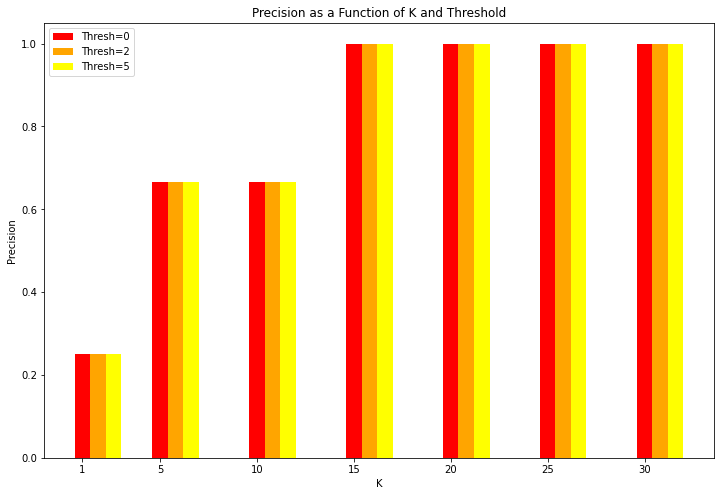

In [32]:
width = 0.8       # the width of the bars
plt.figure(figsize=(12,8))
rects1 = plt.bar(my_xs, my_pres1, width, color='r')
rects2 = plt.bar(np.array(my_xs, int)+width, my_pres2, width, color='orange')
rects3 = plt.bar(np.array(my_xs, float)+2*width, my_pres3, width, color='yellow')
plt.ylabel('Precision')
plt.xlabel('K')
plt.title('Precision as a Function of K and Threshold')
plt.xticks(my_xs)
plt.legend((rects1[0], rects2[0], rects3[0]), ('Thresh=0', 'Thresh=2', 'Thresh=5'))
plt.show()

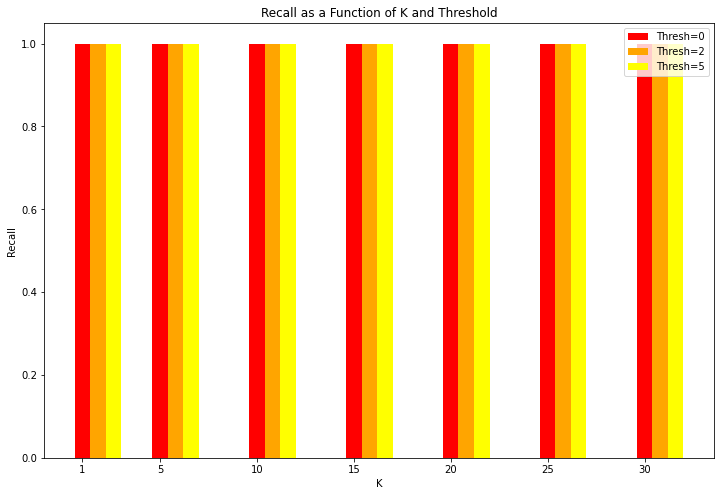

In [41]:
width = 0.8       # the width of the bars
plt.figure(figsize=(12,8))
rects1 = plt.bar(my_xs, my_rec1, width, color='r')
rects2 = plt.bar(np.array(my_xs, int)+width, my_rec2, width, color='orange')
rects3 = plt.bar(np.array(my_xs, float)+2*width, my_rec3, width, color='yellow')
plt.ylabel('Recall')
#plt.ylim((0.995, 1.005))
plt.xlabel('K')
plt.title('Recall as a Function of K and Threshold')
plt.xticks(my_xs)
plt.legend((rects1[0], rects2[0], rects3[0]), ('Thresh=0', 'Thresh=2', 'Thresh=5'))
plt.show()

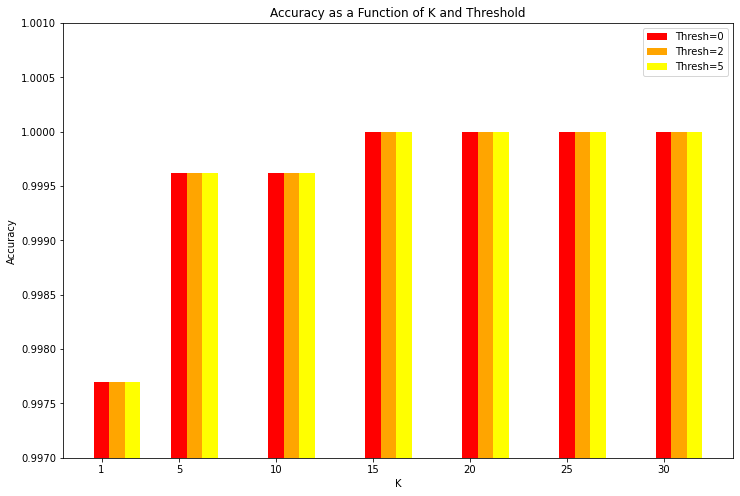

In [45]:
width = 0.8       # the width of the bars
plt.figure(figsize=(12,8))
rects1 = plt.bar(my_xs, my_acc1, width, color='r')
rects2 = plt.bar(np.array(my_xs, int)+width, my_acc2, width, color='orange')
rects3 = plt.bar(np.array(my_xs, float)+2*width, my_acc3, width, color='yellow')
plt.ylim((0.997, 1.001))
plt.ylabel('Accuracy')
plt.xlabel('K')
plt.title('Accuracy as a Function of K and Threshold')
plt.xticks(my_xs)
plt.legend((rects1[0], rects2[0], rects3[0]), ('Thresh=0', 'Thresh=2', 'Thresh=5'))
plt.show()